In [6]:
import vizdoom as vzd
import numpy as np
import matplotlib.pyplot as plt
import random

In [7]:
possible_actions = np.zeros((8,6),dtype=int).tolist()
possible_actions[0] = [1,0,0,0,0]
possible_actions[1] = [0,1,0,0,0]
possible_actions[2] = [0,0,-45,0,0]
possible_actions[3] = [0,0,45,0,0]
possible_actions[4] = [0,0,0,50,0]
possible_actions[5] = [0,0,0,-50,0]
possible_actions[6] = [0,0,0,0,30]
possible_actions[7] = [0,0,0,0,-30]
possible_actions

[[1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, -45, 0, 0],
 [0, 0, 45, 0, 0],
 [0, 0, 0, 50, 0],
 [0, 0, 0, -50, 0],
 [0, 0, 0, 0, 30],
 [0, 0, 0, 0, -30]]

In [95]:
def color_transform(raw_map: np.array):
    map = raw_map.copy()
    
    # Create mask for gray colors (where all RGB values are similar)
    gray_mask = (abs(raw_map[:,:,0] - raw_map[:,:,1]) < 10) & (abs(raw_map[:,:,1] - raw_map[:,:,2]) < 10)
    
    # Create mask for dark brown colors (where R value is low)
    dark_brown_mask = (raw_map[:,:,0] < 100) & (raw_map[:,:,1] < 80) & (raw_map[:,:,2] < 60)
    
    # Set dark browns and grays to black
    map[gray_mask | dark_brown_mask] = [0, 0, 0]
    
    # Set everything else (background browns) to white
    map[~(gray_mask | dark_brown_mask)] = [255, 255, 255]
    
    # Keep the red marker if needed
    map[118:121,158:161,:] = [255,0,0]
    
    return map


In [102]:
def tracing(raw_map: np.array):
    # Create a copy of the input map
    map = raw_map.copy()
    
    # Center point coordinates (slightly adjusted from [120, 160])
    center_y, center_x = 119, 159
    
    # Create empty map with white background
    result = np.ones_like(map) * 255
    
    # Keep the red marker
    result[118:121, 158:161, :] = [255, 0, 0]
    
    # Process only lower half of the map (center_y to end)
    for y in range(center_y, map.shape[0]):
        for x in range(map.shape[1]):
            # Skip if current pixel is white (not a wall)
            if np.all(map[y, x] == [255, 255, 255]):
                continue
                
            # Calculate direction vector from center to current point
            dx = x - center_x
            dy = y - center_y
            
            # Calculate number of steps for ray tracing
            # More steps = more precise but slower
            distance = int(np.sqrt(dx*dx + dy*dy))
            steps = max(distance * 2, 1)
            
            # Step sizes
            step_x = dx / steps
            step_y = dy / steps
            
            # Ray tracing from center to current point
            current_x = float(center_x)
            current_y = float(center_y)
            is_visible = True
            
            # Check each step along the ray
            for step in range(steps):
                # Get current position
                check_x = int(round(current_x))
                check_y = int(round(current_y))
                
                # If we hit a wall before reaching our target point,
                # the target is not visible
                if (check_y, check_x) != (y, x) and np.all(map[check_y, check_x] == [0, 0, 0]):
                    is_visible = False
                    break
                    
                current_x += step_x
                current_y += step_y
            
            # If point is visible, mark it as black in result
            if is_visible:
                result[y, x] = [0, 0, 0]
    
    # Copy the upper half of the map as is
    result[:center_y] = map[:center_y]
    
    return result

In [9]:
# duration 4 tics
def get_pictures(game: vzd.DoomGame):
    state = game.get_state()    
    st = state.screen_buffer.transpose(1,2,0)
    img = np.array([st])
    dph = np.array([state.depth_buffer])
    # turn left
    game.make_action(possible_actions[2])
    state = game.get_state()
    st = state.screen_buffer.transpose(1,2,0)
    img = np.append(img, [st], axis=0)
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.array([dm])
    dph = np.append(dph, [state.depth_buffer], axis=0)
    # turn right
    game.make_action(possible_actions[3],2)
    state = game.get_state()
    st = state.screen_buffer.transpose(1,2,0)
    img = np.append(img, [st], axis=0)
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.append(debug_map, [dm], axis=0)
    dph = np.append(dph, [state.depth_buffer], axis=0)
    # return to center
    game.make_action(possible_actions[2])
    state = game.get_state()
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.append(debug_map, [dm], axis=0)
    #dph = np.append(dph, [state.depth_buffer], axis=0)
    auto_map = state.automap_buffer.transpose(1,2,0)
    #processed_map = map_processing(auto_map)
    processed_map = divide_and_conquer(auto_map)
    #processed_map = tracing(auto_map)
    return img, auto_map, processed_map, debug_map, dph

In [10]:
possible_actions

[[1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, -45, 0, 0],
 [0, 0, 45, 0, 0],
 [0, 0, 0, 50, 0],
 [0, 0, 0, -50, 0],
 [0, 0, 0, 0, 30],
 [0, 0, 0, 0, -30]]

In [11]:
actions_indices = [(4,2,4),(4,3,4),(5,2,5),(5,3,5),(6,2,6),(6,3,6),(7,2,7),(7,3,7),(4,2,6),(4,3,7)]

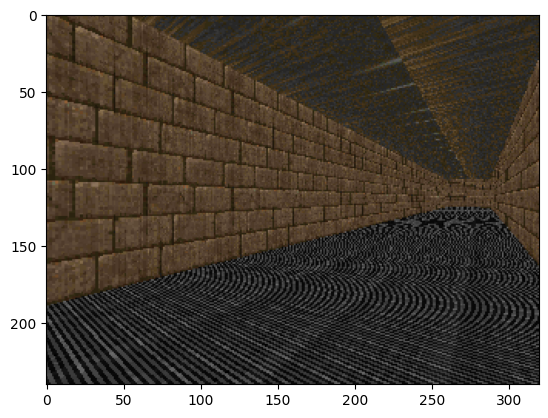

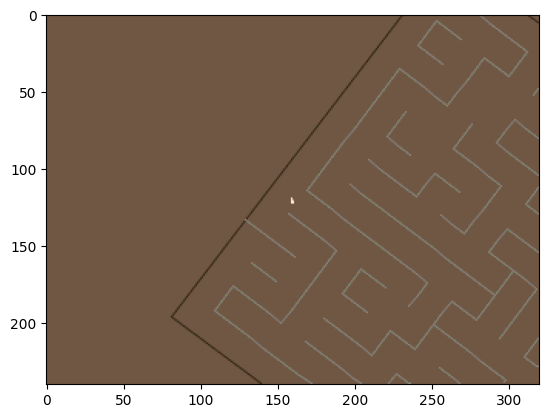

[1.09183459e+03 2.76938635e+03 0.00000000e+00 1.00000000e+00
 4.10000000e+01]


In [12]:
from matplotlib import pyplot as plt

game = vzd.DoomGame()
game.load_config('resources/temp_maps/datagen.cfg')
game.set_doom_scenario_path('data/maps_1key_noaug/30x30.wad')
#game.set_doom_map('map02')
game.set_automap_mode(vzd.AutomapMode.WHOLE)
game.set_render_hud(False)
game.set_available_game_variables([vzd.GameVariable.POSITION_X,vzd.GameVariable.POSITION_Y,vzd.GameVariable.POSITION_Z,vzd.GameVariable.ON_GROUND, vzd.GameVariable.CAMERA_POSITION_Z])
game.set_objects_info_enabled(True)
game.set_screen_format(vzd.ScreenFormat.RGB24)
game.set_labels_buffer_enabled(True)
for i in range(1,2):
    game.set_doom_map(f'map0{i}' if i<10 else f'map{i}')
    
    for j in range(1):
        game.init()
        game.new_episode()
        state = game.get_state()
        st = state.screen_buffer
        img = np.array([st])
        
        plt.imshow(img[0])
        plt.show()
        
        am = state.automap_buffer
        
        plt.imshow(am)
        plt.show()
        
        tmp_position = state.game_variables
        
        print(tmp_position)
        game.close()
    #     break
    #     dph = np.array([state.depth_buffer])
    #     tmp_img, auto_map, tmp_processed_map, debug_map, dph = get_pictures(game)
        
    #     plt.imshow(tmp_processed_map)
    #     plt.show()
        
    #     plt.imshow(auto_map)
    #     plt.show()
        
    #     plt.imshow(debug_map)
    #     plt.show()
        
    #     tmp_position = state.game_variables
    #     temp_objects = state.objects
    #     inner_objects = [{'x': obj.position_x, 'y': obj.position_y, 'z': obj.position_z, 'angle': obj.angle} for obj in temp_objects if obj.name == 'RedCard']
    #     inner_images = np.array([tmp_img])
    #     inner_maps = np.array([tmp_processed_map])
    #     inner_positions = np.array([tmp_position])
    #     inner_depth = np.array([dph])
    #     for action_index in actions_indices[j]:
    #         game.make_action(possible_actions[action_index],7)
    #         if game.is_episode_finished():
    #             game.new_episode()
    #         state = game.get_state()
    #         #st = state.screen_buffer.transpose(1,2,0)
    #         #img = np.array([st])
    #         #am = state.automap_buffer.transpose(1,2,0)
    #         #dph = np.array([state.depth_buffer])
    #         tmp_img, auto_map, tmp_processed_map, debug_map, dph = get_pictures(game)
    #         tmp_position = state.game_variables
    #         inner_images = np.append(inner_images,[tmp_img],axis=0)
    #         inner_maps = np.append(inner_maps,[tmp_processed_map],axis=0)
    #         inner_positions = np.append(inner_positions,[tmp_position],axis=0)    
    #         inner_depth = np.append(inner_depth,[dph],axis=0)     
    #     if i==0 and j==0:
    #         images = np.array([inner_images])
    #         maps = np.array([inner_maps])
    #         positions = np.array([inner_positions])
    #         depth = np.array([inner_depth])
    #     else:
    #         images = np.append(images,[inner_images],axis=0)
    #         maps = np.append(maps,[inner_maps],axis=0)
    #         positions = np.append(positions,[inner_positions],axis=0)    
    #         depth = np.append(depth,[inner_depth],axis=0)
    #     game.close()    
    # if i==0:
    #     objects = np.array([inner_objects])
    # else:
    #     objects = np.append(objects,[inner_objects],axis=0)

In [18]:
print(np.unique(am[:,:,0]))
print(np.unique(am[:,:,1]))
print(np.unique(am[:,:,2]))


[ 43  47  51  55  63  71  79  83  87  91  95 255]
[  0  27  35  43  47  51  59  63  67  71  75 255]
[  0  11  15  19  23  27  35  43  47  51  55 255]


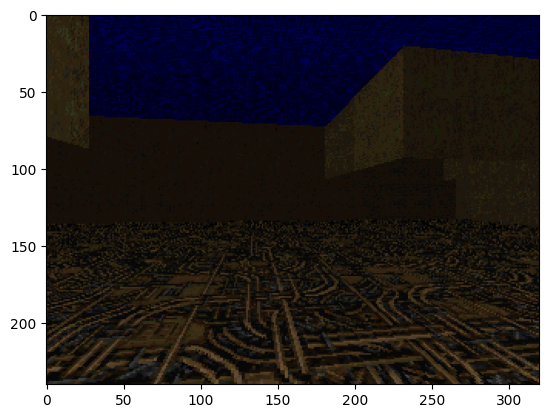

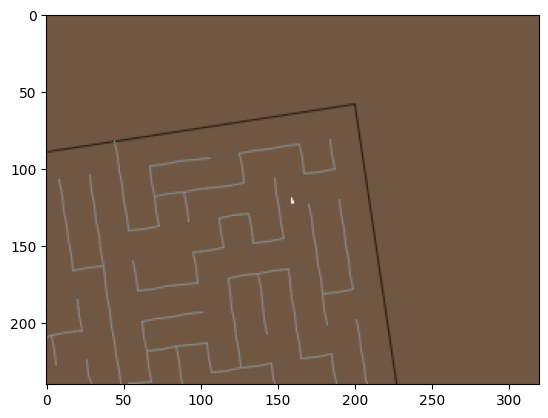

[531.38925171 587.51531982   0.           1.          41.        ]


In [99]:
from matplotlib import pyplot as plt

game = vzd.DoomGame()
game.load_config('resources/temp_maps/datagen.cfg')
game.set_doom_scenario_path('data/maps_1key_noaug/30x30.wad')
#game.set_doom_map('map02')
game.set_automap_mode(vzd.AutomapMode.WHOLE)
game.set_render_hud(False)
game.set_available_game_variables([vzd.GameVariable.POSITION_X,vzd.GameVariable.POSITION_Y,vzd.GameVariable.POSITION_Z,vzd.GameVariable.ON_GROUND, vzd.GameVariable.CAMERA_POSITION_Z])
game.set_objects_info_enabled(True)
game.set_screen_format(vzd.ScreenFormat.RGB24)
game.set_labels_buffer_enabled(True)
for i in range(1,2):
    game.set_doom_map(f'map0{i}' if i<10 else f'map{i}')
    
    for j in range(1):
        game.init()
        game.new_episode()
        state = game.get_state()
        st = state.screen_buffer
        img = np.array([st])
        
        plt.imshow(img[0])
        plt.show()
        
        am = state.automap_buffer
        
        plt.imshow(am)
        plt.show()
        
        tmp_position = state.game_variables
        
        print(tmp_position)
        game.close()
    #     break
    #     dph = np.array([state.depth_buffer])
    #     tmp_img, auto_map, tmp_processed_map, debug_map, dph = get_pictures(game)
        
    #     plt.imshow(tmp_processed_map)
    #     plt.show()
        
    #     plt.imshow(auto_map)
    #     plt.show()
        
    #     plt.imshow(debug_map)
    #     plt.show()
        
    #     tmp_position = state.game_variables
    #     temp_objects = state.objects
    #     inner_objects = [{'x': obj.position_x, 'y': obj.position_y, 'z': obj.position_z, 'angle': obj.angle} for obj in temp_objects if obj.name == 'RedCard']
    #     inner_images = np.array([tmp_img])
    #     inner_maps = np.array([tmp_processed_map])
    #     inner_positions = np.array([tmp_position])
    #     inner_depth = np.array([dph])
    #     for action_index in actions_indices[j]:
    #         game.make_action(possible_actions[action_index],7)
    #         if game.is_episode_finished():
    #             game.new_episode()
    #         state = game.get_state()
    #         #st = state.screen_buffer.transpose(1,2,0)
    #         #img = np.array([st])
    #         #am = state.automap_buffer.transpose(1,2,0)
    #         #dph = np.array([state.depth_buffer])
    #         tmp_img, auto_map, tmp_processed_map, debug_map, dph = get_pictures(game)
    #         tmp_position = state.game_variables
    #         inner_images = np.append(inner_images,[tmp_img],axis=0)
    #         inner_maps = np.append(inner_maps,[tmp_processed_map],axis=0)
    #         inner_positions = np.append(inner_positions,[tmp_position],axis=0)    
    #         inner_depth = np.append(inner_depth,[dph],axis=0)     
    #     if i==0 and j==0:
    #         images = np.array([inner_images])
    #         maps = np.array([inner_maps])
    #         positions = np.array([inner_positions])
    #         depth = np.array([inner_depth])
    #     else:
    #         images = np.append(images,[inner_images],axis=0)
    #         maps = np.append(maps,[inner_maps],axis=0)
    #         positions = np.append(positions,[inner_positions],axis=0)    
    #         depth = np.append(depth,[inner_depth],axis=0)
    #     game.close()    
    # if i==0:
    #     objects = np.array([inner_objects])
    # else:
    #     objects = np.append(objects,[inner_objects],axis=0)

In [68]:
s = set()
for i in range(240):
    for j in range(320):
        s.add((int(am[i,j,0]),int(am[i,j,1]),int(am[i,j,2])))
s


{(43, 35, 15),
 (47, 27, 11),
 (51, 43, 19),
 (55, 35, 19),
 (63, 43, 27),
 (63, 47, 23),
 (71, 51, 35),
 (79, 59, 35),
 (79, 59, 43),
 (83, 63, 47),
 (87, 67, 51),
 (91, 71, 43),
 (95, 75, 55),
 (103, 83, 63),
 (111, 87, 67),
 (119, 95, 75),
 (119, 119, 119),
 (123, 99, 79),
 (123, 127, 99),
 (127, 127, 127),
 (131, 107, 87),
 (131, 131, 131),
 (139, 139, 139),
 (255, 235, 219)}

In [69]:
np.where(am==list(s)[0])


(array([  1,   1,   1, ..., 238, 238, 238]),
 array([104, 104, 104, ..., 194, 194, 194]),
 array([0, 1, 2, ..., 0, 1, 2]))

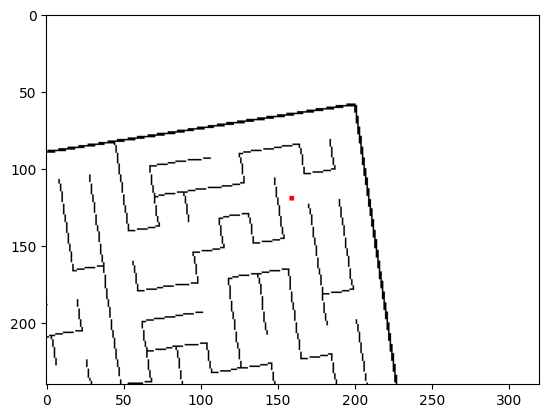

In [103]:
plt.imshow(color_transform(am))
m = color_transform(am)

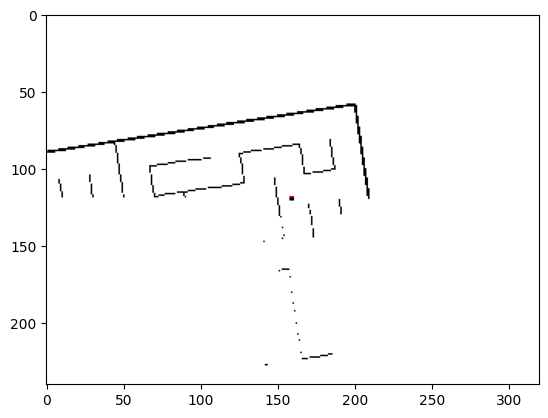

In [104]:
plt.imshow(tracing(m))
plt.show()


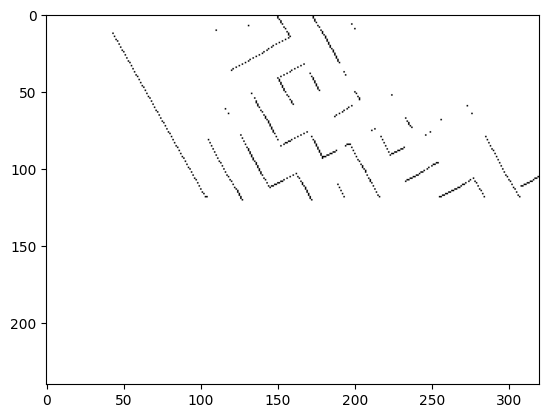

In [82]:
plt.imshow(divide_and_conquer(m))
plt.show()


In [146]:
temp_copy_images = images.copy()
temp_copy_maps = maps.copy()
temp_copy_positions = positions.copy()
temp_copy_depth = depth.copy()
temp_copy_objects = objects.copy()


In [148]:
positions_list = [{'x': pos[0], 'y': pos[1], 'z': pos[2], 'angle': pos[3]} for pos in positions]
np.savez('data/99maps_data.npz', images=temp_copy_images, maps=temp_copy_maps, positions=temp_copy_positions,depth=temp_copy_depth,objects=temp_copy_objects)

In [150]:
# Load the data from 99maps_data.npz
#data = np.load('data/99maps_data.npz')
#maps = data['maps']
#images = data['images'] 
#positions = data['positions']
#depth = data['depth']
#objects = data['objects']

# Get dimensions
n_maps = 99
samples_per_map = maps.shape[0] // n_maps

# Split data into 99 parts
maps_split = np.array_split(maps, n_maps)
images_split = np.array_split(images, n_maps) 
positions_split = np.array_split(positions, n_maps)
depth_split = np.array_split(depth, n_maps)

# Save each split as separate file
for i in range(n_maps):
    np.savez(f'data/maps/map{i+1}_data.npz',
             maps=maps_split[i],
             images=images_split[i],
             positions=positions_split[i],
             depth=depth_split[i],
             objects=objects[i])


ValueError: Object arrays cannot be loaded when allow_pickle=False

In [151]:
images.shape,maps.shape,positions.shape,depth.shape,objects.shape

((990, 4, 3, 240, 320, 3),
 (990, 4, 240, 320, 3),
 (990, 4, 4),
 (990, 4, 3, 240, 320),
 (99, 1))

In [125]:
print(len(objects))
for i in range(len(objects)):
    print(f'{objects[i].name}: x={objects[i].position_x}, y={objects[i].position_y}, z={objects[i].position_z}, angle={objects[i].angle}')

3


AttributeError: 'numpy.ndarray' object has no attribute 'name'

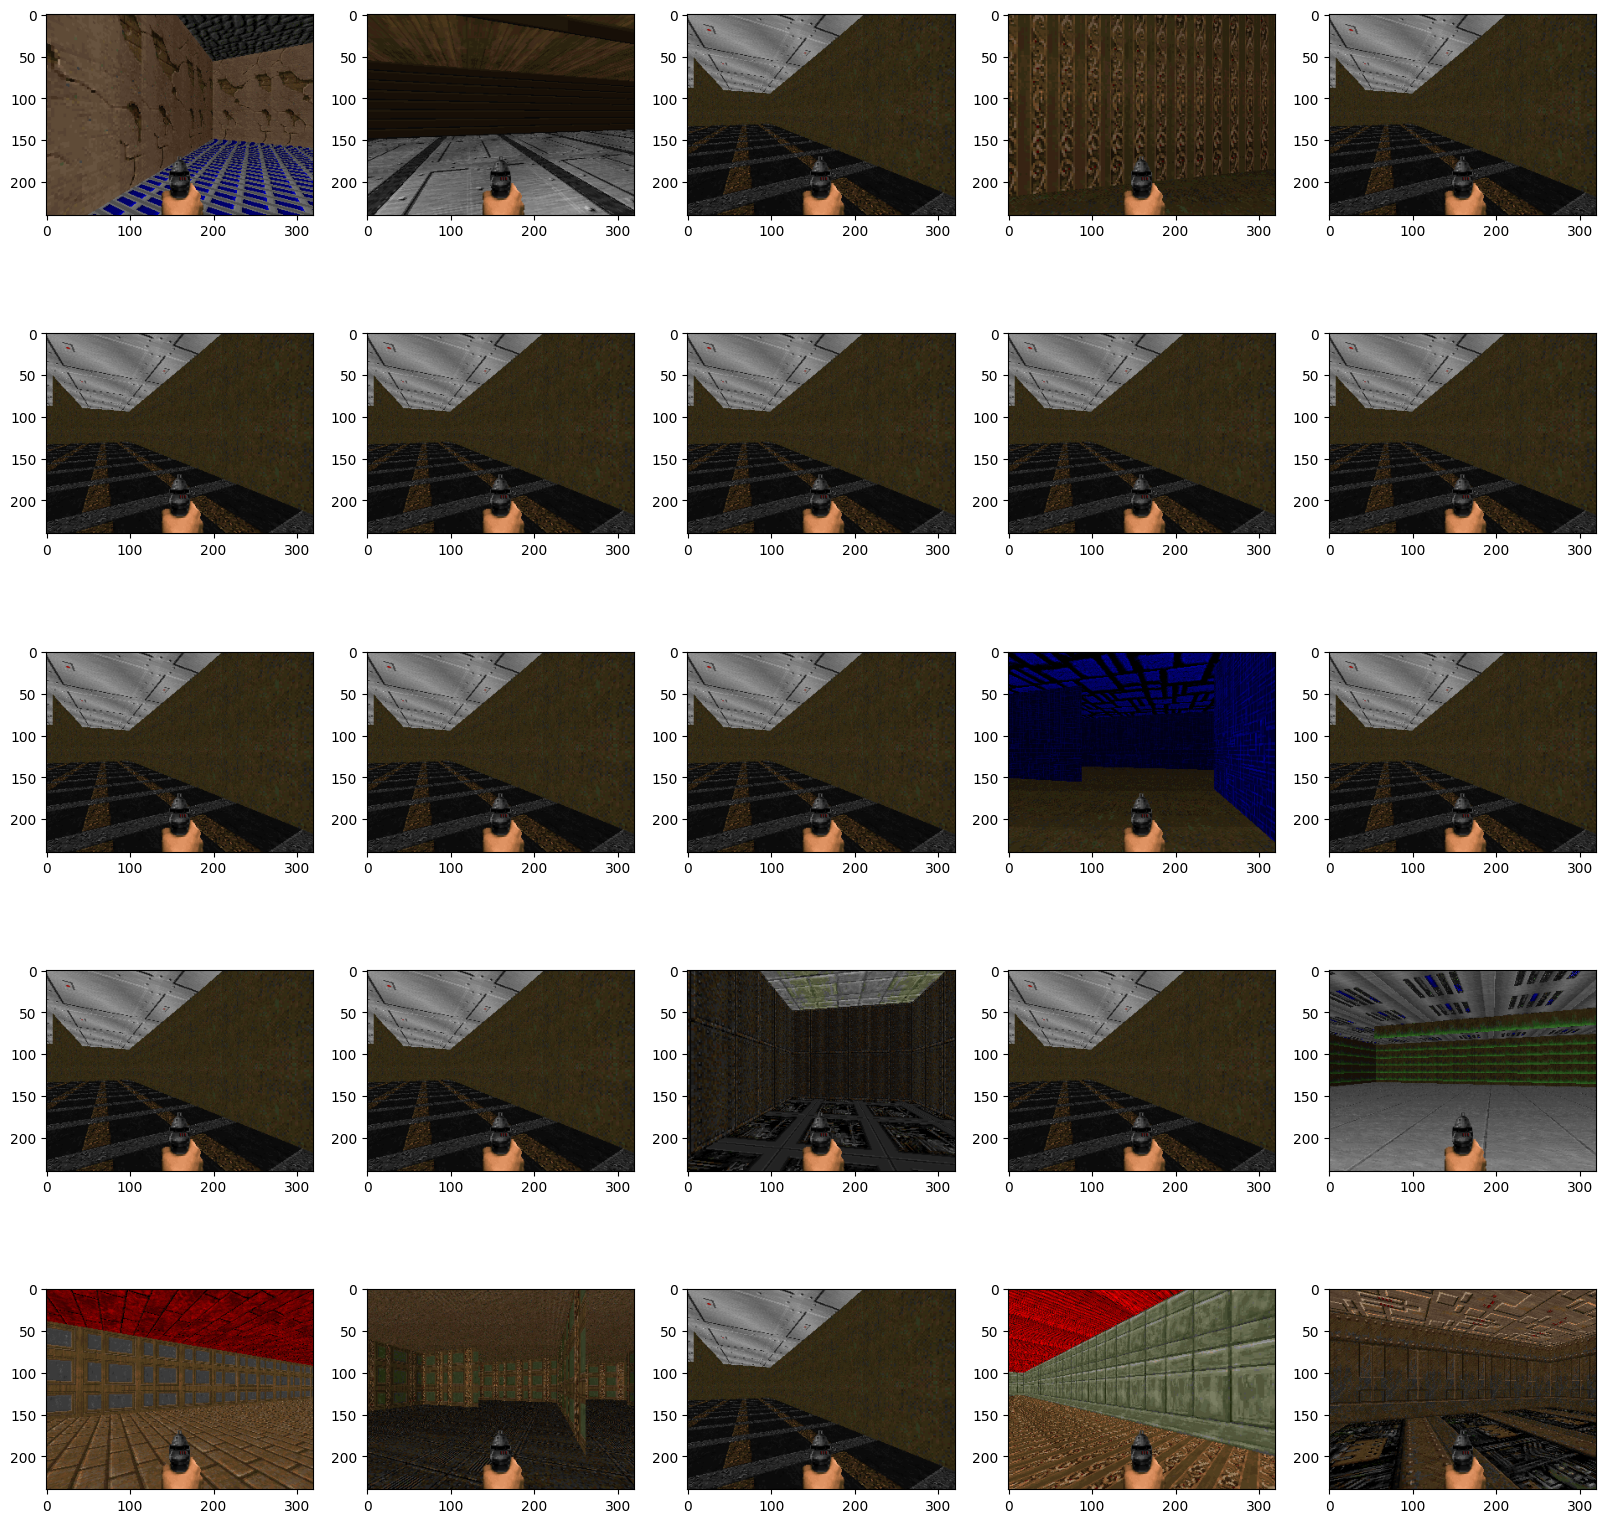

In [63]:
fig, ax = plt.subplots(5,5,figsize=(20,20))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j,0])
plt.show()


In [40]:

np.savez('data/map1_data.npz', images=images, maps=maps, positions=positions_list,depth=depth,objects=objects)

In [57]:
# Print all positions
[print(f'x={a['x']}, y={a['y']}, z={a['z']}, angle={a['angle']}') for a in positions_list]
positions_list = [{'x': pos[0], 'y': pos[1], 'z': pos[2], 'angle': pos[3]} for pos in positions]
# Get unique x,y coordinate pairs
unique_positions = set((pos['x'], pos['y']) for pos in positions_list)
print(f"\nNumber of unique (x,y) positions: {len(unique_positions)}")

x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
x=878.8865966796875, y=1338.0102996826172, z=0.0, angle=101.22802736731899
x=1249.3342742919922, y=1071.9305419921875, z=0.0, angle=313.76953132305516
x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
x=1488.8721008300781, y=1531.221908569336, z=0.0, angle=190.38208012245178
x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
x=661.58251953125, y=1029.5327911376953, z=0.0, angle=221.62170415316282
x=180.13064575195312, y=344.8828887939453, z=0.0, angle=39.336547860721254
x=456.0449523925781, y=1076.643798828125, z=0.0, angle=208.2733154781799
x=155.45095825195312, y=953.6021423339844, z=0.0, angle=339.85107429787774
x=1467.6954803466797, y=1494.9478607177734, z=0.0, angle=133.84643557803855
x=868.7358703613281, y=768.7713165283203, z=0.0, angle=245.99487310415014
x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.682

In [13]:
data = np.load('data/mywayhome_data.npz')
d1 = data['maps']
d2 = data['images']
d3 = data['positions']
#positions_list = [{'x': pos[0], 'y': pos[1], 'z': pos[2], 'angle': pos[3]} for pos in d3]
[print(f'x={a['x']}, y={a['y']}, z={a['z']}, angle={a['angle']}') for a in positions_list]



x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=686.64599609375, y=-62.38200378417969, z=0.0, angle=109.73144533804884
x=1039.3280029296875, y=-169.88400268554688, z=0.0, angle=285.8917236993768
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=460.3260040283203, y=-596.1199951171875, z=0.0, angle=184.41101078512403
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=464.09800720214844, y=-60.496002197265625, z=0.0, angle=13.37036133123803
x=460.3260040283203, y=-596.1199951171875, z=0.0, angle=117.81188967586772
x=464.0, y=-176.0, z=0.0, angle=354.4024659028282
x=464.0, y=-176.0, z=0.0, angle=221.5008545437597
x=460.3260040283203, y=56.436004638671875, z=0.0, angle=147.35412601087106
x=686.8300018310547, y=-173.2469940185547, z=0.0, angle=120.9265137000304
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

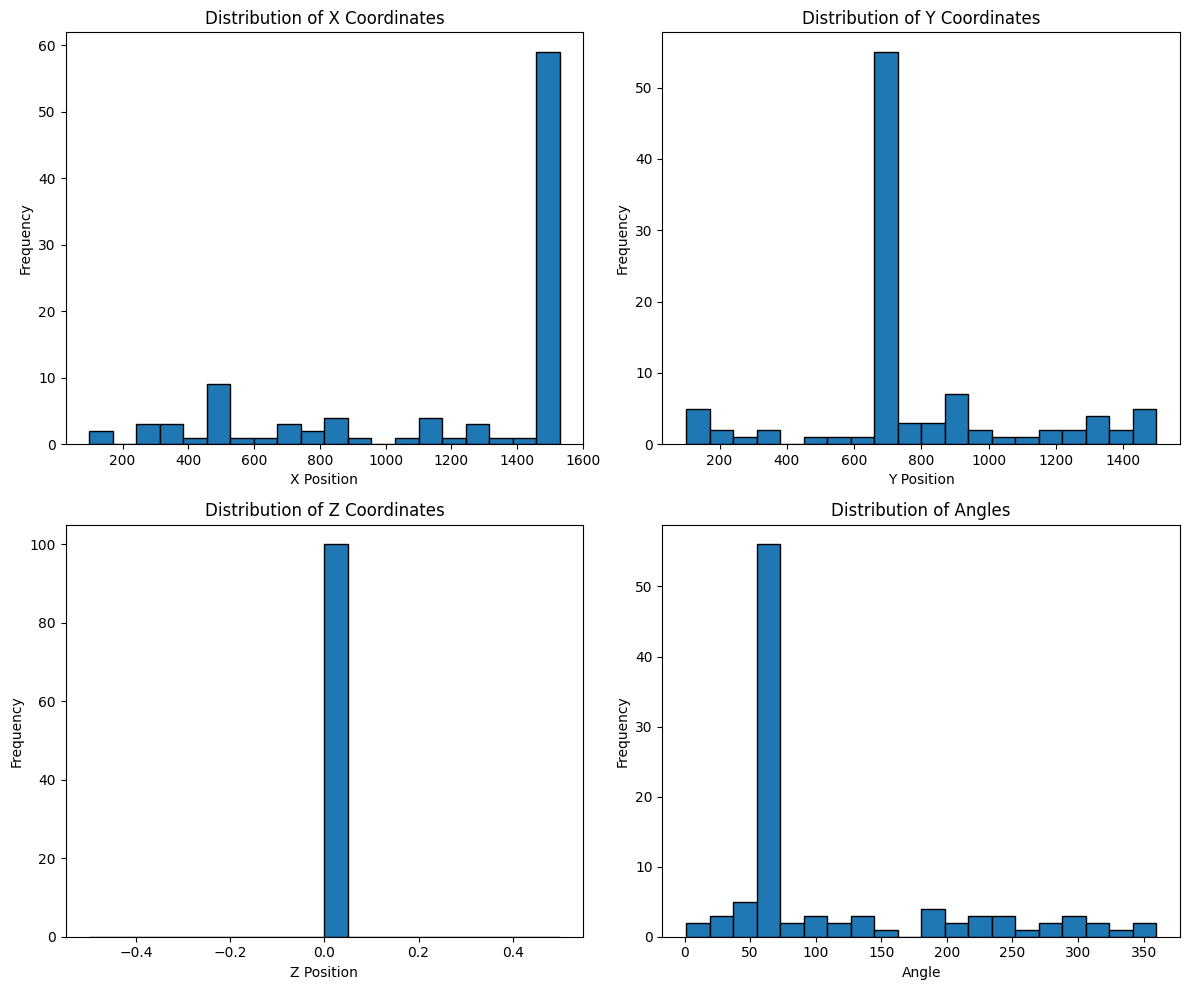

In [64]:
# Create separate lists for each coordinate
x_coords = [pos['x'] for pos in positions_list]
y_coords = [pos['y'] for pos in positions_list]
z_coords = [pos['z'] for pos in positions_list]
angles = [pos['angle'] for pos in positions_list]

# Create subplots for distributions
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms
ax1.hist(x_coords, bins=20, edgecolor='black')
ax1.set_title('Distribution of X Coordinates')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Frequency')

ax2.hist(y_coords, bins=20, edgecolor='black')
ax2.set_title('Distribution of Y Coordinates')
ax2.set_xlabel('Y Position')
ax2.set_ylabel('Frequency')

ax3.hist(z_coords, bins=20, edgecolor='black')
ax3.set_title('Distribution of Z Coordinates')
ax3.set_xlabel('Z Position')
ax3.set_ylabel('Frequency')

ax4.hist(angles, bins=20, edgecolor='black')
ax4.set_title('Distribution of Angles')
ax4.set_xlabel('Angle')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


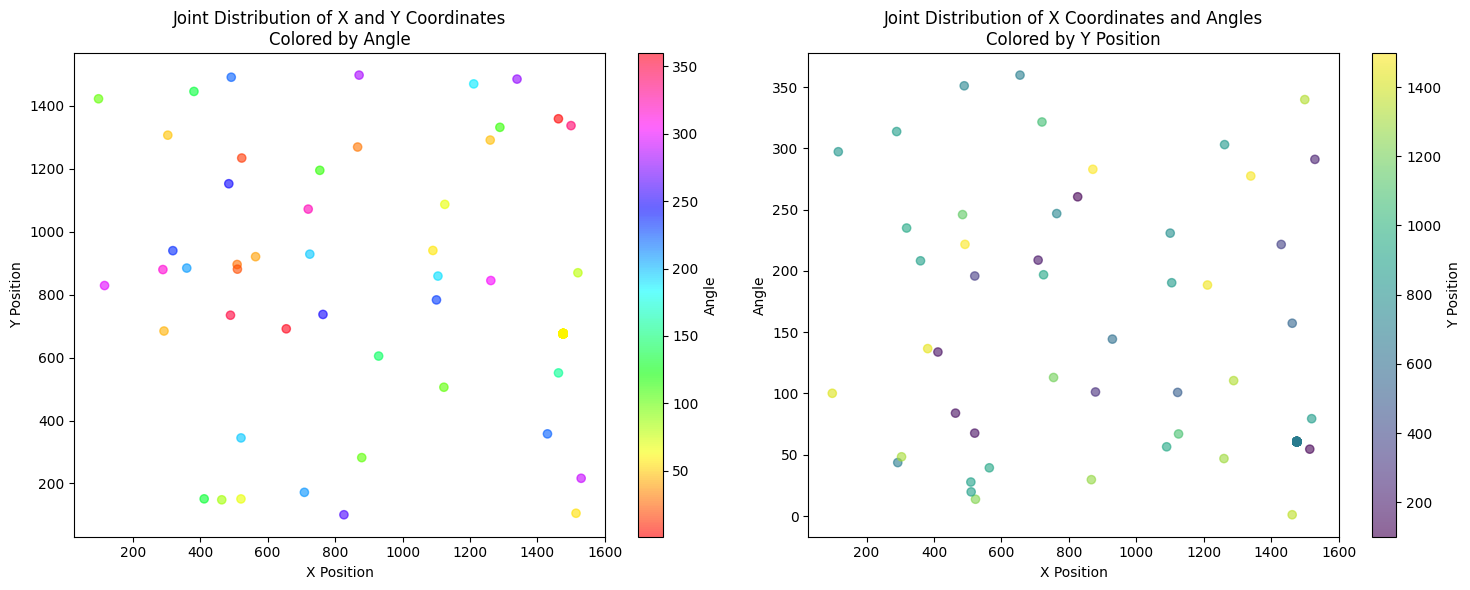

In [65]:
# Create figure for joint distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot X vs Y scatter
scatter = ax1.scatter(x_coords, y_coords, c=angles, cmap='hsv', alpha=0.6)
ax1.set_title('Joint Distribution of X and Y Coordinates\nColored by Angle')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
plt.colorbar(scatter, ax=ax1, label='Angle')

# Plot angle distribution vs X position
scatter2 = ax2.scatter(x_coords, angles, c=y_coords, cmap='viridis', alpha=0.6)
ax2.set_title('Joint Distribution of X Coordinates and Angles\nColored by Y Position')
ax2.set_xlabel('X Position')
ax2.set_ylabel('Angle')
plt.colorbar(scatter2, ax=ax2, label='Y Position')

plt.tight_layout()
plt.show()


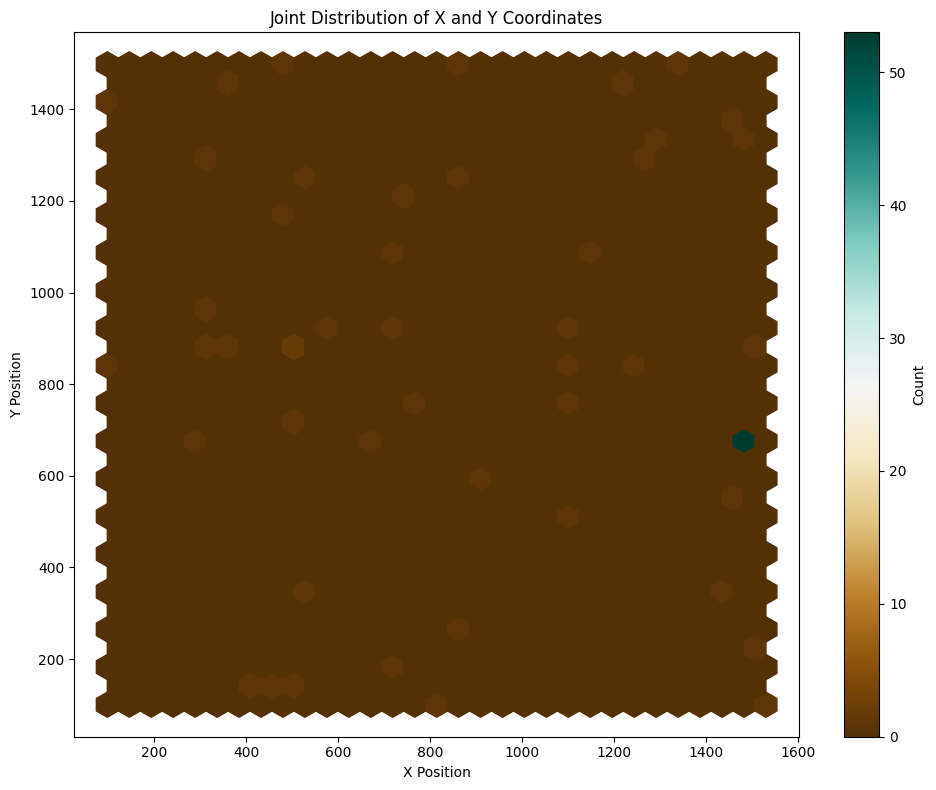

In [66]:
# Create figure for joint distribution
plt.figure(figsize=(10, 8))

# Create joint distribution plot using hexbin
plt.hexbin(x_coords, y_coords, gridsize=30, cmap='BrBG') # YlOrRd
plt.colorbar(label='Count')

plt.title('Joint Distribution of X and Y Coordinates')
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.tight_layout()
plt.show()
